# Computational Bionics: Project Exercise 1

Group members:
- Yash Waware (12329556)
- Julian Lork (12243805)
- Florian Frech (12308544)

------------------------

## Task 1: Basic System Model
### 1.1 Description

The following section considers the combination of the sub models of the leg and the **hip drive**.

A PID controller which controls the hip angle according to the provided gait data.
The model only considers the swing phase. The simulation is started at toe off and stops when the leg has ground contact again. In the swing phase there are no acting ground reaction forces and foot moments.

An ideal digital controller (no quantization) with a sampling time of $dt = 0.1$ seconds is used.
$$f = \frac{1}{dt} = 10 Hz$$

Further, an ideal analog sensor for the hip and knee angle is used. The hip and knee angles $q_1$ and $q_2$ are directly used without quantization.

A simple ideal damper in the knee is used to stabilize the system:
$$M_2 = D \cdot \omega_2$$

**PID Controller**

We consider the classic PID (Proprtional-Integrating-Differential) controller

$$u(t) = K_p e(t) + K_I \int e(t) dt + K_D \frac{de(t)}{dt}$$

$$G_R(s) = K_P + \frac{K_I}{s} + K_D s = \frac{K_D s^2 + K_P s + K_I}{s}$$

 - $K_P$: controller gain
 - $K_I$: integrator gain
 - $K_D$: differentiator gain

#### 1.2 Simplified Box Model

### 1.3 Implementation

In [1]:
import sympy as sp
from sympy import sin, cos, Matrix, pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize

**PID Controller**

In [41]:
# Class PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd, T):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.T = T
        self.e_km1 = 0
        self.e_km2 = 0
        self.u_km1 = 0
        pass

    def compute_control(self, reference, state):
        e_k = reference - state
        a0 = self.Kp #+ self.Kd / self.T
        a1 = (self.Ki * self.T - 2 * self.Kd / self.T - self.Kp)
        a2 = self.Kd / self.T

        u_k = self.u_km1 + a0 * e_k + a1 * self.e_km1 + a2 * self.e_km2

        self.u_km1 = u_k
        self.e_km2 = self.e_km1
        self.e_km1 = e_k

        return u_k

**Parameters**

In [3]:
# Parameters Leg Model
m_body = 100 # Body mass [kg]
m1_val = 9.73; m2_val = 5.07; m3_val = 0.44 # Masses [kg]

L1_val = 0.41; l1_val = L1_val / 2 # Lengths thigh [m]
L2_val = 0.415; l2_val = L2_val / 2 # Lengths shank [m]

r_G1 = 0.132; r_G2 = 0.125 # Radius of gyration [m]
J1_val = m1_val * r_G1**2; J2_val = m2_val * r_G2**2 # Moments of inertia [kg m^2]

D_val = 0.1 # Damping coefficients [N m s/rad]

g_val = 9.81 # Gravity [m/s^2]

# Parameters Motor
U_M = 16 # V - motor voltage
U_rated = 48 # V - rated voltage
R_M = 0.151 # Ohm - resistance
L_M = 121e-6 # H - inductance
n_0 = 12916 # rpm - no load speed
w_0 = 2 * np.pi * n_0 / 60 # rad/s
k_n = n_0 * 2 * np.pi / (60 * U_rated) # rad/(Vs) - speed constant
k_M = 0.03 # Nm/A - torque constant
i_G = 60 # gear ratio
eta_G = 0.85 # gear efficiency

#### 1.3.1 Leg Model

In [4]:
# Define the symbolic variables
q1, q2, omega1, omega2 = sp.symbols(r'q_1 q_2 \omega_1 \omega_2')
dot_omega1, dot_omega2 = sp.symbols(r'\dot{\omega}_1 \dot{\omega}_2')
l1, l2, L1, L2 = sp.symbols(r'l_1 l_2 L_1 L_2')
m1, m2, m3 = sp.symbols(r'm_1 m_2 m_3')
J1, J2 = sp.symbols(r'J_1 J_2')
M_drive = sp.symbols(r'M_{drive}')
D = sp.symbols(r'D')
t, g = sp.symbols('t g')

q1 = sp.Function('q_1')(t)
q2 = sp.Function('q_2')(t)

w1 = q1.diff(t)
w2 = q2.diff(t)

dot_w1 = w1.diff(t)
dot_w2 = w2.diff(t)

# Subustitute dictionary
parameterDict = {m1: m1_val, m2: m2_val, m3: m3_val,
                L1: L1_val, l1: l1_val, L2: L2_val, l2: l2_val,
                J1: J1_val, J2: J2_val,
                g: g_val}

**Euler-Lagrange Formulation**

*Angles in radian*

![](LowerLimb.png)

In [5]:
# Position of the center of mass for tigh, shank and foot
r1 = Matrix([l1 * sin(q1),
             -l1 * cos(q1)])

r2 = Matrix([L1 * sin(q1) + l2 * sin(q2),
             -L1 * cos(q1) - l2 * cos(q2)])

r3 = Matrix([L1 * sin(q1) + L2 * sin(q2),
            -L1 * cos(q1) - L2 * cos(q2)])

# Velocity of the center of mass for tigh, shank and foot
v1 = r1.diff(t)
v2 = r2.diff(t)
v3 = r3.diff(t)

# Kinetic energy of the system
T1 = 0.5 * m1 * v1.dot(v1) + 0.5 * J1 * q1.diff(t)**2
T2 = 0.5 * m2 * v2.dot(v2) + 0.5 * J2 * q2.diff(t)**2
T3 = 0.5 * m3 * v3.dot(v3)
T_total = T1 + T2 + T3

# Potential energy of the system
h1 = -l1 * cos(q1)
h2 = -L1 * cos(q1) - l2 * cos(q2)
h3 = -L1 * cos(q1) - L2 * cos(q2)
V1 = m1 * g * h1
V2 = m2 * g * h2
V3 = m3 * g * h3
V_total = V1 + V2 + V3

L = T_total - V_total

**Setting up the system of Equations**

In [6]:
dL_d_dot_q1 = L.diff(q1.diff(t))
dL_d_dot_q2 = L.diff(q2.diff(t))

dL_d_dot_q1_dt = dL_d_dot_q1.diff(t)
dL_d_dot_q2_dt = dL_d_dot_q2.diff(t)

dL_dq1 = L.diff(q1)
dL_dq2 = L.diff(q2)

# Substitute the values of the parameters
subsDict = {q1.diff(t): omega1,
            q2.diff(t): omega2,
            q1.diff(t, 2): dot_omega1,
            q2.diff(t, 2): dot_omega2,}

dL_d_dot_q1_dt.subs(subsDict).simplify()
dL_d_dot_q2_dt.subs(subsDict).simplify()

dL_dq1.subs(subsDict).simplify()
dL_dq2.subs(subsDict).simplify()

Q1 = M_drive            # Hip:  External torque from the motor 
Q2 = - D * q2.diff(t)   # Knee: Damping introduced

Q1.subs(subsDict).simplify()
Q2.subs(subsDict).simplify();

In [7]:
# Set up the equations
eq1 = dL_d_dot_q1_dt - dL_dq1 - Q1
eq2 = dL_d_dot_q2_dt - dL_dq2 - Q2

eq1 = eq1.subs(subsDict).simplify()
eq2 = eq2.subs(subsDict).simplify()

# Solve for omega1_dot and omega2_dot
sol = sp.solve([eq1, eq2], (dot_omega1, dot_omega2))

# Extracting and simplifying the solutions
dot_omega1_sol = sol[dot_omega1].simplify()
dot_omega2_sol = sol[dot_omega2].simplify()

**Defining the parameters**

In [8]:
# Substitute the values of the parameters
dot_omega1_sol = dot_omega1_sol.subs(parameterDict)
dot_omega2_sol = dot_omega2_sol.subs(parameterDict)

# Lambdify the equations
dot_omega1_func = sp.lambdify((q1, q2, omega1, omega2, M_drive, D), dot_omega1_sol, 'numpy')
dot_omega2_func = sp.lambdify((q1, q2, omega1, omega2, M_drive, D), dot_omega2_sol, 'numpy')

**Read provided Gait Data**

In [250]:
# Read gait data
filename = 'gait_data.xls'
gait_data = pd.read_excel(filename, engine='xlrd')

# Extract gait data
gait_step = np.array(gait_data["gait"][1:].values)

GRFx = np.array(gait_data["GRFx"][1:]) * m_body
GRFz = np.array(gait_data["GRFz"][1:]) * m_body

MX_F = np.array(gait_data["MX_F"][1:]) * m_body
MX_K = np.array(gait_data["MX_K"][1:]) * m_body
MX_H = np.array(gait_data["MX_H"][1:]) * m_body

q1_array = np.array(gait_data["Flex_Ext_H"][1:]) * np.pi / 180 # in radians
q2_array = np.array(gait_data["Flex_Ext_K"][1:]) * np.pi / 180 # in radians

**Analyis the start and end of the swing phase**

In [251]:
np.where(np.abs(MX_F)< 1)

(array([ 0, 14, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
        79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
        96, 97, 98, 99], dtype=int64),)

*Consider start of the swing phase at 64 % of the gait cycle*:

In [252]:
# Find start of the swing phase - no ground reaction forces and foot moment
threshold = 1
start_swing = np.where(np.abs(MX_F)< threshold)[0][2]

q1_swing_array = q1_array[start_swing:]
q2_swing_array = q2_array[start_swing:]

# deivative of the joint angles
dq1_array = np.gradient(q1_swing_array)
dq2_array = np.gradient(q2_swing_array)

q1_min = np.min(q1_swing_array)
q1_max = np.max(q1_swing_array)

q2_min = np.min(q2_swing_array)
q2_max = np.max(q2_swing_array)

print(f"q1_min: {q1_min:.2f}, q1_max: {q1_max:.2f}")
print(f"q2_min: {q2_min:.2f}, q2_max: {q2_max:.2f}")

q1_min: 1.17, q1_max: 1.70
q2_min: 2.09, q2_max: 3.23


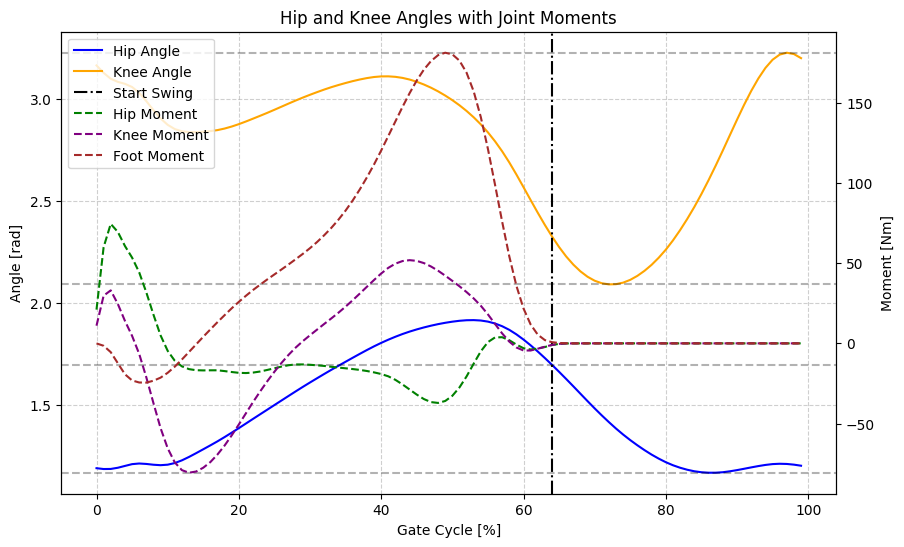

In [268]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot hip and knee angles on the primary y-axis
ax1.plot(q1_array, label='Hip Angle', color='b')
ax1.plot(q2_array, label='Knee Angle', color='orange')
ax1.axvline(start_swing, color='black', linestyle='-.', label='Start Swing')

# Mark the min and max angles in the swing phase
ax1.axhline(q1_min, color='black', linestyle='--', alpha=0.3)
ax1.axhline(q1_max, color='black', linestyle='--', alpha=0.3)
ax1.axhline(q2_min, color='black', linestyle='--', alpha=0.3)
ax1.axhline(q2_max, color='black', linestyle='--', alpha=0.3)
ax1.set_xlabel('Gate Cycle [%]')
ax1.set_ylabel('Angle [rad]', color='black')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='black')

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot joint moments on the secondary y-axis
ax2.plot(MX_H, label='Hip Moment', color='g', linestyle='--')
ax2.plot(MX_K, label='Knee Moment', color='purple', linestyle='--')
ax2.plot(MX_F, label='Foot Moment', color='brown', linestyle='--')
ax2.set_ylabel('Moment [Nm]', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Hip and Knee Angles with Joint Moments')

# Show the plot
plt.show()

In [269]:
# Leg Model
def leg_model(t, y, M_motor, damp_coef):
    omega1, omega2, q1, q2 = y

    domega1 = dot_omega1_func(q1, q2, omega1, omega2, M_motor, damp_coef)
    domega2 = dot_omega2_func(q1, q2, omega1, omega2, M_motor, damp_coef)

    dq1 = omega1
    dq2 = omega2

    return [domega1, domega2, dq1, dq2]

#### 1.3.2 Hip Drive Model

In [270]:
# Dynamic model equations
def motor_model(t, y, u_control, omega_m):
    M = y
    U = U_M * u_control
    n = i_G * omega_m * 30 / np.pi
    I = M / (k_M * i_G * eta_G)
    dI = (U - R_M * I - n / k_n) / L_M
    dM = eta_G * i_G * k_M * dI
    return [dM]

In [271]:
# Function of the complete system for the solver
def system_equations(t, y, u_control, damp):
    dydt_leg = leg_model(t, y[0:4], y[4], damp)
    dydt_motor = motor_model(t, y[4], u_control, y[0])
    return dydt_leg + dydt_motor

In [272]:
# Initial value
omega1_0 = dq1_array[0] # Initial angular velocity of the thigh
omega2_0 = dq2_array[0] # Initial angular velocity of the shank
q1_0 = q1_swing_array[0] # Initial angle of the thigh
q2_0 = q2_swing_array[0] # Initial angle of the shank
MH_0 = 0 # Initial torque


initial_state = [omega1_0, omega2_0, q1_0, q2_0, MH_0]

dt_control = 0.1
dt_sim = 0.01
t_start = 0
t_end = len(q1_swing_array) * dt_control
t_control = np.arange(t_start, t_end, dt_control)
num_steps = len(t_control)

In [273]:
# Simulation
def simulation(params):
    Kp, Ki, Kd, damp = params
    controller = PIDController(Kp, Ki, Kd, dt_control)

    # Lists for overall results
    t_total = []
    y_total = []
    ref_array = []

    current_state = initial_state

    for t in t_control:
        ref = q1_swing_array[int(t / dt_control)]
        measured = current_state[2]

        u_control = controller.compute_control(ref, measured)
        if u_control > 1: u_control = 1
        if u_control < -1: u_control = -1

        #print(f"Time: {t:.2f}, Reference: {ref:.2f}, Measured: {measured:.2f}, Control: {u_control:.2f}")

        # Define the time span for the current controller interval
        t_span = [t, min(t + controller.T, t_end)]

        # Calculate the time points for t_eval
        t_eval = np.linspace(t_span[0], t_span[1], int((t_span[1] - t_span[0]) / dt_sim) + 1)

        # Solve the ODE for the current interval, passing the torque as an argument
        sol = solve_ivp(system_equations, t_span, current_state, args=(u_control, damp), t_eval=t_eval, method='BDF', dense_output=True)

        # Update the current state
        current_state = sol.y[:, -1]

        # Store time and state values
        if len(t_total) == 0:
            t_total.extend(sol.t)
            y_total.extend(sol.y.T)
            ref_array.extend([ref] * len(sol.t))
            
        else:
            t_total.extend(sol.t[1:])
            y_total.extend(sol.y.T[1:])
            ref_array.extend([ref] * len(sol.t[1:]))

    return t_total, y_total, ref_array

In [274]:
# Objective function for optimization
def cost_function(params):
    t_sol, y_sol, ref_sol = simulation(params)

    total_error = np.sum(np.abs(np.array(y_sol)[:, 2] - np.array(ref_sol))**2)
    print(f"Kp: {params[0]:.2f} Ki: {params[1]:.2f} Kd: {params[2]:.2f} Error: {total_error:.2f}")

    return total_error

In [327]:
# Initial values for the PID parameters Kp, Ki, Kd
Kp = 25
Ki = 0.0001
Kd = 0.0001
Damp = 0.8

initial_params = [Kp, Ki, Kd, Damp]

# bounds for the PID parameters
bounds = [(0, 500), (0, 500), (0, 500), (0, 1)]

total_error = 0
total_u_control = 0

# Run the optimization
#result = minimize(cost_function, initial_params, bounds=bounds, method='L-BFGS-B')

#Optimized PID parameters:  2.495113452858258 16.290133885300854 0.296132030348925

# Optimized PID parameters
#Kp, Ki, Kd = result.x
print("Optimized PID parameters: ", Kp, Ki, Kd)

Optimized PID parameters:  25 0.0001 0.0001


In [328]:
t_sol, y_sol, ref_sol = simulation([Kp, Ki, Kd, Damp])
q1_sol = np.array(y_sol)[:, 2]
q2_sol = np.array(y_sol)[:, 3]
omega1_sol = np.array(y_sol)[:, 0]
omega2_sol = np.array(y_sol)[:, 1]

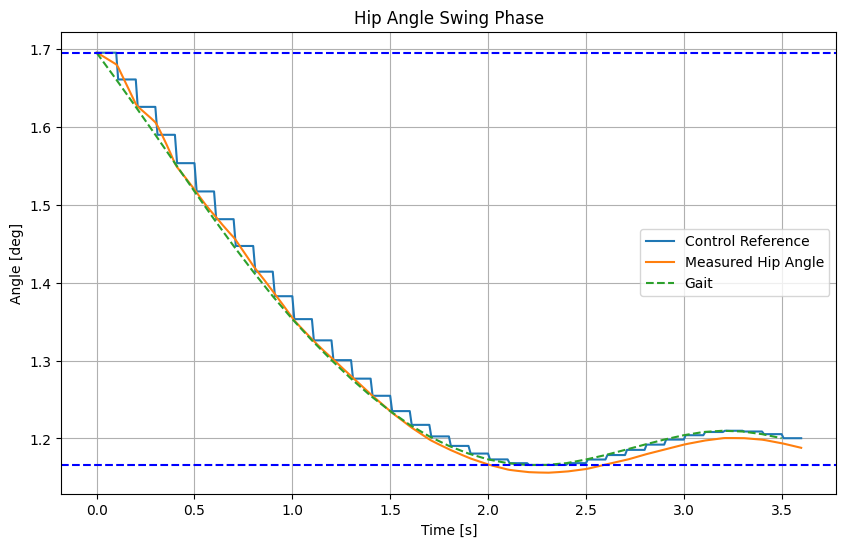

In [330]:
t_vals = np.arange(0, len(q1_swing_array) * dt_control, dt_control)
# Plot the results - angles
plt.figure(figsize=(10, 6))
plt.plot(t_sol, ref_sol, label='Control Reference')
plt.plot(t_sol, q1_sol, label='Measured Hip Angle')
# plt.plot(t_sol, q2_sol, label='Resulting Knee Angle')
# plot reference knee angle
# plt.plot(t_vals, q2_swing_array, label='Reference Knee Angle', linestyle='--')
plt.plot(t_vals, q1_swing_array, label='Gait', linestyle='--')
# plot minimum and maximum angles
plt.axhline(y=q1_min, color='b', linestyle='--')
plt.axhline(y=q1_max, color='b', linestyle='--')
# plt.axhline(y=q2_min, color='g', linestyle='--')
# plt.axhline(y=q2_max, color='g', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.legend()
plt.title('Hip Angle Swing Phase')
plt.grid()
plt.show()

### Validation - Stable Knee Angle

----------------------------------------

## Task 2: Real Sensor

### 2.1 Description

The controller output is now quantized.

The hip angle is measured using a potentiometer.

An ADC with an input range of 0 to 3 V is considered.

Measurement noises in the sensor with a standard deviation of $\sigma = 10 \space mV$ are taken into account.

### 2.2 Updated Simplified Box Model

### 2.3 Simulation with Real Sensor

In [127]:
# Sensor
U_0_pot = 5 # V
U_ADC = 3 # V
n_bits = 8

alpha_max = 270 # deg
theta_max = np.max(q1_swing_array)
theta_min = np.min(q1_swing_array) 
print(f"theta_min: {theta_min:.2f}°\ntheta_max: {theta_max:.2f}°")

frac_min = theta_min / alpha_max
frac_max = theta_max / alpha_max
R4 = 20e3 # Ohm
R3 = (1 - frac_min) / frac_min * R4
print(f"R3: {R3:.2f} Ohm")

def sensor(q, noise_std):
    is_scalar = np.isscalar(q)
    q = np.atleast_1d(q)

    alpha = q * alpha_max / 180
    U_a = U_0_pot * (frac_max - alpha / alpha_max)

    # Add Gaussian noise
    mean = 0
    U_a_noisy = np.random.normal(mean, noise_std, q.shape)

    # Overlay signal with noise
    U_a_noisy = np.array(U_a + U_a_noisy)

    U_a_noisy[U_a_noisy < 0] = 0
    U_a_noisy[U_a_noisy > U_0_pot] = U_0_pot

    # Numver of quantization levels
    Q = 2**n_bits - 1

    # Quantize the signal
    delta = U_ADC / Q
    U_a_quantized = delta * np.round(U_a_noisy / delta)

    if is_scalar:
        return U_a_quantized[0]
    
    return U_a_quantized

theta_min: 66.80°
theta_max: 97.15°
R3: 60838.35 Ohm
